# Example 2: Cytotoxicity Contact Analysis

In this notebook we will demonstrate:
1. Convert segmented label data to sparse Pandas table
2. Use the label and sparse position table to return contact analysis across multiple frames
3. Remapping the cell feature table to ultrack results

In [1]:
from cyto.postprocessing.graph import *
from cyto.utils.label_to_table import *
import dask_image.imread
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
import pyclesperanto_prototype as cle
from skimage import exposure
import pandas as pd


## Load image files
pyCyto supports any image loader compatible with numpy/dask. Bioimages may storage in multiple formats and dimension orders. Here we load list of single image files under same directory with Dask Image, utilizing the lazy loading function to facilitate the pipeline optimization. For large dataset dask array is more preferable than numpy for better memory managements.

In [2]:
CANCER_IMAGE_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/register_denoise_gamma_channel_merged_cancer_ROI/*.tif"
TCELL_IMAGE_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/register_denoise_gamma_channel_merged_Tcell_ROI/*.tif"

CANCER_LABEL_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/register_denoise_gamma_channel_merged_cancer_ROI_masks/*.tif"
TCELL_LABEL_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/register_denoise_gamma_channel_merged_Tcell_ROI_masks/*.tif"

In [3]:
# default chunk size: 1 image
image_cancer = dask_image.imread.imread(CANCER_IMAGE_PATH_PATTERN)
image_tcell = dask_image.imread.imread(TCELL_IMAGE_PATH_PATTERN)

label_cancer = dask_image.imread.imread(CANCER_LABEL_PATH_PATTERN)
label_tcell = dask_image.imread.imread(TCELL_LABEL_PATH_PATTERN)

image_cancer

dask.array<_map_read_frame, shape=(8640, 1000, 1000), dtype=uint16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>

Have a first glance of the images

Text(0.5, 1.0, 'T Cell Labels')

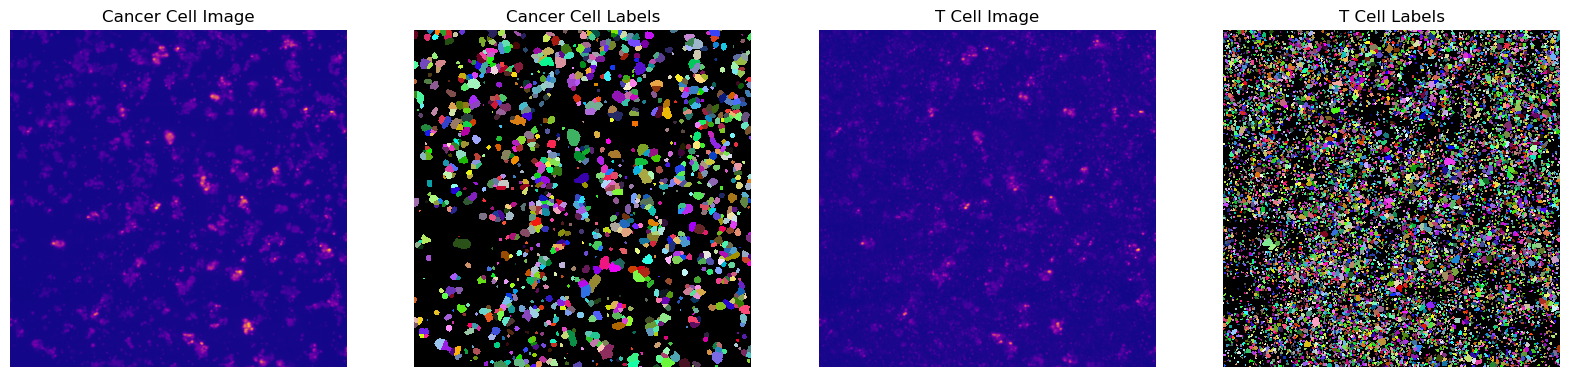

In [4]:
fig, axs = plt.subplots(1,4,figsize=(20,5))

axs[0].imshow(image_cancer[0,:,:],cmap="plasma")
axs[0].set_axis_off()
axs[0].set_title("Cancer Cell Image")

cle.imshow(label_cancer[0,:,:], labels=True, plot=axs[1])
axs[1].set_axis_off()
axs[1].set_title("Cancer Cell Labels")

axs[2].imshow(image_tcell[0,:,:],cmap="plasma")
axs[2].set_axis_off()
axs[2].set_title("T Cell Image")

cle.imshow(label_tcell[0,:,:], labels=True, plot=axs[3])
axs[3].set_axis_off()
axs[3].set_title("T Cell Labels")


## 1. Convert Dense Cell Masks to Sparse Pandas Table

In [5]:
FRAMES = 100 # define number of frames to perform contact analysis

In [6]:
# convert segmentation mask to trackpy style array
features = {}

# note that pyCyto works in XYT dim order but dask/tiff is in TYX, need to transpose the array
# TODO: pixel spacing
features["cancer"] = label_to_sparse(label=label_cancer[:FRAMES,:,:].T,image=image_cancer[:FRAMES,:,:].T,spacing=[1,1],channel_name="cancer")

features["tcell"] = label_to_sparse(label=label_tcell[:FRAMES,:,:].T,image=image_tcell[:FRAMES,:,:].T,spacing=[1,1],channel_name="tcell")

100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


In [7]:
features["cancer"]

label           y           x  bbox_xstart  bbox_ystart  bbox_xsize  \
0            1  472.585952  317.597659          293          453          52   
1            2  142.222810  633.487915          617          115          34   
2            3  535.442224  748.133797          725          518          55   
3            4  685.534222  434.730667          412          665          44   
4            5  606.487106  197.601719          179          587          38   
...        ...         ...         ...          ...          ...         ...   
121407  121408  305.176471  563.235294          561          303           6   
121408  121409  911.058824  637.647059          636          909           5   
121409  121410  165.562500  182.687500          181          164           5   
121410  121411  765.000000  337.562500          336          763           4   
121411  121412  741.625000  477.562500          476          740           5   

        bbox_ysize           i           j  bbox_istart  ...  feret_diameter  \
0               42  317.597659  472.585952        293.0  ...       53.488316   
1               53  633.487915  142.222810        617.0  ...       52.345009   
2               37  748.133797  535.442224        725.0  ...       56.612719   
3               43  434.730667  685.534222        412.0  ...       46.324939   
4               41  197.601719  606.487106        179.0  ...       41.761226   
...            ...         ...         ...          ...  ...             ...   
121407           5  563.235294  305.176471        561.0  ...        5.000000   
121408           5  637.647059  911.058824        636.0  ...        4.472136   
121409           4  182.687500  165.562500        181.0  ...        4.472136   
121410           5  337.562500  765.000000        336.0  ...        5.000000   
121411           4  477.562500  741.625000        476.0  ...        5.000000   

        feret_radius   perimeter        mass         mean       median  \
0          26.744158  148.801077  15623847.0  9626.523105  9228.855469   
1          26.172505  144.223441  11211521.0  8467.916163  7659.214844   
2          28.306360  143.342758   6819866.0  5925.165943  6089.574219   
3          23.162470  135.988320   6567633.0  5837.896000  5865.339844   
4          20.880613  121.470014  10382658.0  9916.578797  8219.800781   
...              ...         ...         ...          ...          ...   
121407      2.500000   17.199823     79780.0  4692.941176  4907.144531   
121408      2.236068   15.073666    113978.0  6704.588235  6982.449219   
121409      2.236068   15.629027     87341.0  5458.812500  5562.503906   
121410      2.500000   18.865904     61879.0  3867.437500  3924.105469   
121411      2.500000   16.184387     93065.0  5816.562500  5780.957031   

                 sd  frame  channel  alive  
0       4698.160008      0   cancer    NaN  
1       4185.782957      0   cancer    NaN  
2       1770.658758      0   cancer    NaN  
3       1607.486737      0   cancer    NaN  
4       5744.402120      0   cancer    NaN  
...             ...    ...      ...    ...  
121407   874.539698     99   cancer    NaN  
121408  1336.187536     99   cancer    NaN  
121409   975.632254     99   cancer    NaN  
121410   161.469076     99   cancer    NaN  
121411   995.245160     99   cancer    NaN  

[121412 rows x 27 columns]

In [8]:
features["tcell"]

label           y           x  bbox_xstart  bbox_ystart  \
0              1  670.849246  390.738693          378          655   
1              2  132.066532  630.483871          618          116   
2              3  274.956790  865.415638          851          264   
3              4  691.069930  680.552448          667          675   
4              5  659.125874  729.431235          717          648   
...          ...         ...         ...          ...          ...   
1006717  1006718  287.200000  967.133333          965          285   
1006718  1006719  284.800000  973.933333          972          283   
1006719  1006720  769.200000  975.800000          974          768   
1006720  1006721  131.600000  992.400000          991          130   
1006721  1006722   89.200000  993.933333          992           88   

         bbox_xsize  bbox_ysize           i           j  bbox_istart  ...  \
0                25          35  390.738693  670.849246        378.0  ...   
1                24          32  630.483871  132.066532        618.0  ...   
2                30          23  865.415638  274.956790        851.0  ...   
3                25          28  680.552448  691.069930        667.0  ...   
4                29          22  729.431235  659.125874        717.0  ...   
...             ...         ...         ...         ...          ...  ...   
1006717           5           5  967.133333  287.200000        965.0  ...   
1006718           5           5  973.933333  284.800000        972.0  ...   
1006719           5           4  975.800000  769.200000        974.0  ...   
1006720           4           4  992.400000  131.600000        991.0  ...   
1006721           5           4  993.933333   89.200000        992.0  ...   

         feret_diameter  feret_radius  perimeter       mass         mean  \
0             34.132096     17.066048  98.907157  3940048.0  6599.745394   
1             31.400637     15.700318  90.537283  4193311.0  8454.256048   
2             30.675723     15.337862  84.293566  3094097.0  6366.454733   
3             30.232433     15.116216  82.167409  2948162.0  6872.172494   
4             31.304952     15.652476  84.388851  2956619.0  6891.885781   
...                 ...           ...        ...        ...          ...   
1006717        4.472136      2.236068  14.518306    57250.0  3816.666667   
1006718        4.472136      2.236068  14.518306    55615.0  3707.666667   
1006719        4.472136      2.236068  14.288268    62361.0  4157.400000   
1006720        4.242641      2.121320  13.502870    52613.0  3507.533333   
1006721        4.472136      2.236068  14.288268    52297.0  3486.466667   

              median           sd  frame  channel  alive  
0        6001.556641  2274.345323      0    tcell    NaN  
1        7269.779297  4148.664472      0    tcell    NaN  
2        5886.263672  1875.136901      0    tcell    NaN  
3        5770.970703  3270.370277      0    tcell    NaN  
4        6808.607422  1809.146731      0    tcell    NaN  
...              ...          ...    ...      ...    ...  
1006717  3875.857422   177.095078     99    tcell    NaN  
1006718  3769.556641   167.495274     99    tcell    NaN  
1006719  4088.458984   286.050145     99    tcell    NaN  
1006720  3556.955078    82.687766     99    tcell    NaN  
1006721  3450.654297    64.756540     99    tcell    NaN  

[1006722 rows x 27 columns]

## 2. Contact Analysis and Add Contact Tracing to the Result Table

In [9]:
# Prepare data for pyCyto processing, beware of order of data input, here we calculate the T Cell to Cancer Cell contact
data = {}
data["images"] = [image_tcell[:FRAMES,:,:].T,image_cancer[:FRAMES,:,:].T]
data["labels"] = [label_tcell[:FRAMES,:,:].T,label_cancer[:FRAMES,:,:].T]
data["features"] = [features["tcell"], features["cancer"]]

In [10]:
# Cross cell contact measurementsSimple plot of the contact time with the contact table output
cccm = CrossCellContactMeasures(base_image=True)
res = cccm(data)

100%|██████████| 100/100 [29:26<00:00, 17.66s/it]


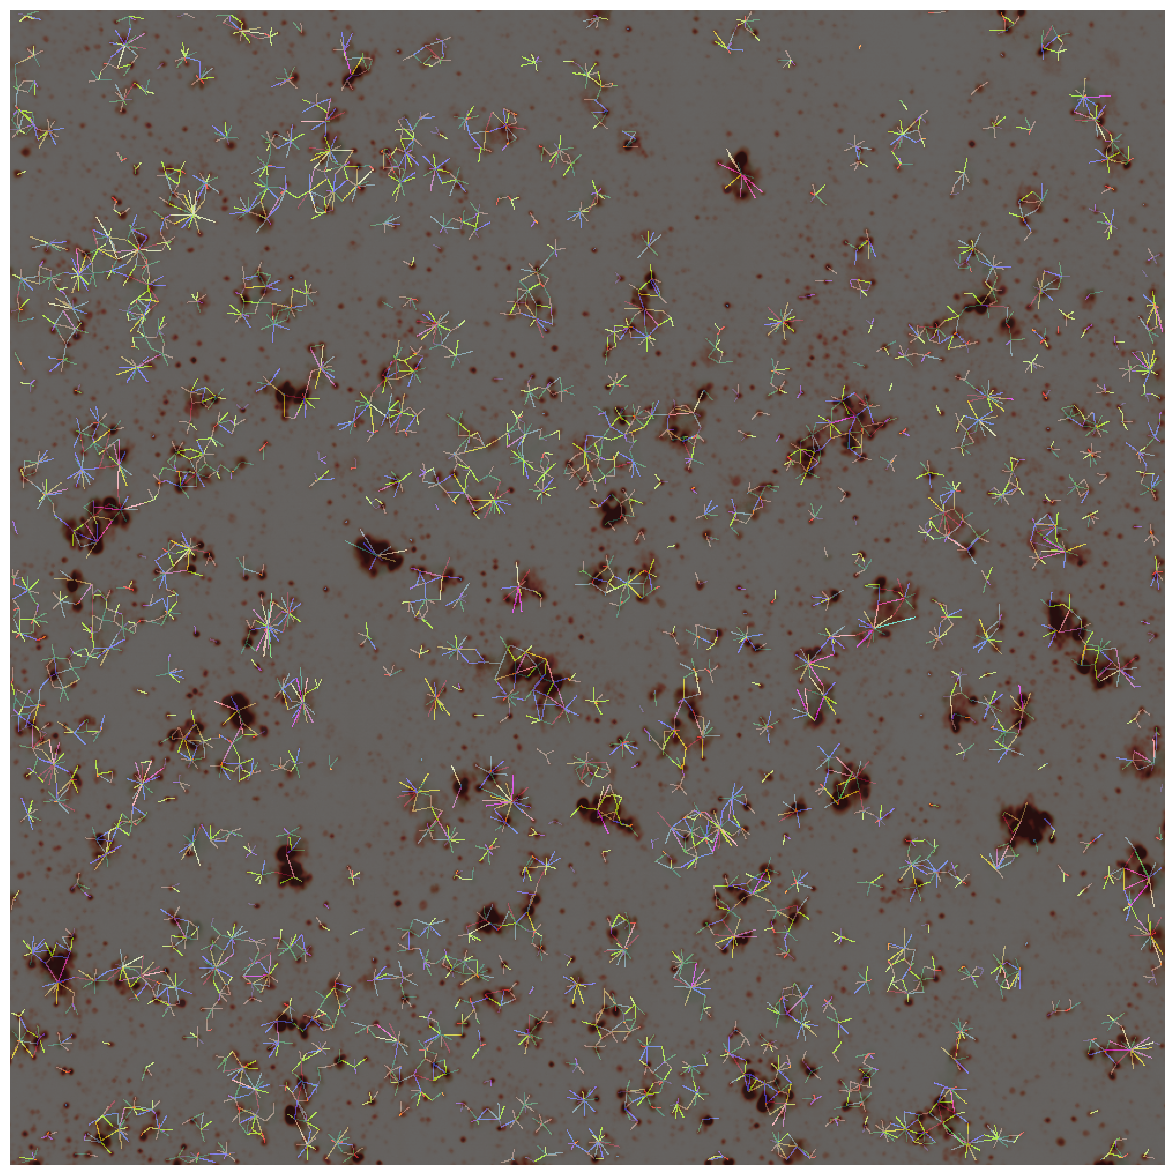

In [11]:
network_image = res["image"]

fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_axis_off()
tail = 1
pl, pu = np.percentile(image_cancer[0,:,:].T.ravel(), (tail, 100-tail))
ax.imshow(exposure.rescale_intensity(image_cancer[0,:,:].T, in_range=(pl.compute(), pu.compute()),out_range=(0,255)),cmap='Greens',alpha=0.7)
pl, pu = np.percentile(image_tcell[0,:,:].T.ravel(), (tail, 100-tail))
ax.imshow(exposure.rescale_intensity(image_tcell[0,:,:].T, in_range=(pl.compute(), pu.compute()),out_range=(0,255)),cmap='Reds',alpha=0.7)
cle.imshow(network_image[:,:,0], labels=True, plot=ax, alpha=0.6)

In [12]:
# get the cell features
features["tcell"] = res["feature"]
features["tcell"]

label           y           x  bbox_xstart  bbox_ystart  \
0              1  670.849246  390.738693          378          655   
1              2  132.066532  630.483871          618          116   
2              3  274.956790  865.415638          851          264   
3              4  691.069930  680.552448          667          675   
4              5  659.125874  729.431235          717          648   
...          ...         ...         ...          ...          ...   
1006717  1006718  287.200000  967.133333          965          285   
1006718  1006719  284.800000  973.933333          972          283   
1006719  1006720  769.200000  975.800000          974          768   
1006720  1006721  131.600000  992.400000          991          130   
1006721  1006722   89.200000  993.933333          992           88   

         bbox_xsize  bbox_ysize           i           j  bbox_istart  ...  \
0                25          35  390.738693  670.849246        378.0  ...   
1                24          32  630.483871  132.066532        618.0  ...   
2                30          23  865.415638  274.956790        851.0  ...   
3                25          28  680.552448  691.069930        667.0  ...   
4                29          22  729.431235  659.125874        717.0  ...   
...             ...         ...         ...         ...          ...  ...   
1006717           5           5  967.133333  287.200000        965.0  ...   
1006718           5           5  973.933333  284.800000        972.0  ...   
1006719           5           4  975.800000  769.200000        974.0  ...   
1006720           4           4  992.400000  131.600000        991.0  ...   
1006721           5           4  993.933333   89.200000        992.0  ...   

              mass         mean       median           sd  frame  channel  \
0        3940048.0  6599.745394  6001.556641  2274.345323      0    tcell   
1        4193311.0  8454.256048  7269.779297  4148.664472      0    tcell   
2        3094097.0  6366.454733  5886.263672  1875.136901      0    tcell   
3        2948162.0  6872.172494  5770.970703  3270.370277      0    tcell   
4        2956619.0  6891.885781  6808.607422  1809.146731      0    tcell   
...            ...          ...          ...          ...    ...      ...   
1006717    57250.0  3816.666667  3875.857422   177.095078     99    tcell   
1006718    55615.0  3707.666667  3769.556641   167.495274     99    tcell   
1006719    62361.0  4157.400000  4088.458984   286.050145     99    tcell   
1006720    52613.0  3507.533333  3556.955078    82.687766     99    tcell   
1006721    52297.0  3486.466667  3450.654297    64.756540     99    tcell   

         alive  contact  contacting cell labels  closest cell dist  
0          NaN     True                    [30]           1.678074  
1          NaN     True                     [2]          10.591233  
2          NaN     True              [240, 250]           4.563784  
3          NaN     True                    [59]           2.580832  
4          NaN     True                [19, 43]           6.320714  
...        ...      ...                     ...                ...  
1006717    NaN    False                      []          10.618454  
1006718    NaN    False                      []          12.628018  
1006719    NaN     True        [120264, 120695]           9.078635  
1006720    NaN    False                      []          41.155411  
1006721    NaN    False                      []          45.172066  

[1006722 rows x 30 columns]

The last three columns `contact`, `contacting cell labels` and `closest cells dist` are the corresponding contacting cancer cells.

Currently we only provide the nearest contacted cell but not the averaged one. The list of `contacting cell labels` are the corresponding label number in `features["cancer"]`

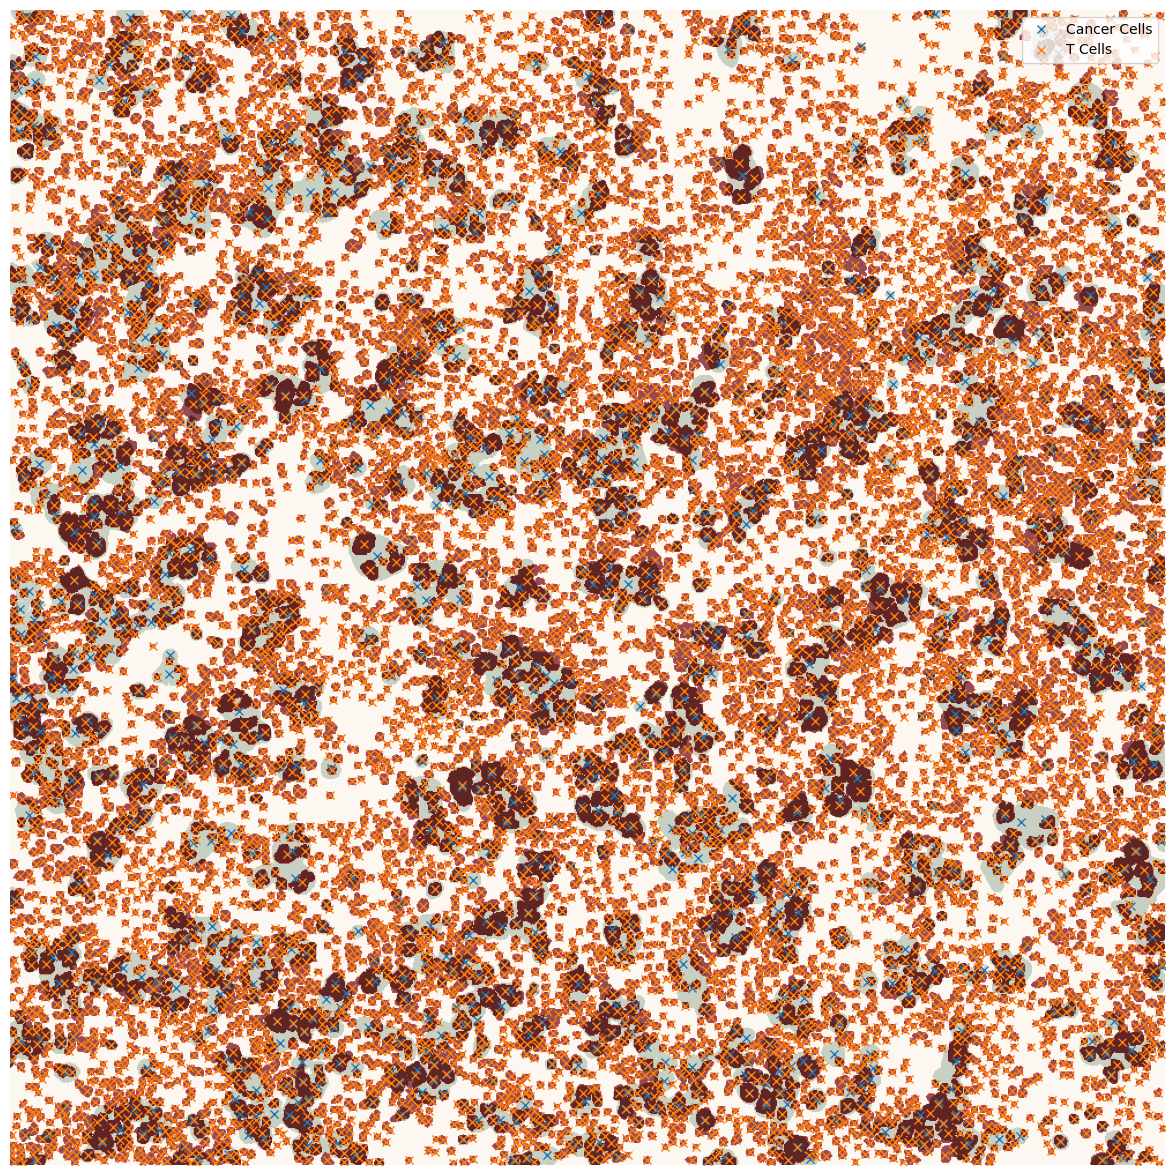

In [13]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
ax.set_axis_off()
tail = 1
frame = label_cancer[0,:,:].T
ax.imshow(exposure.rescale_intensity(frame, in_range=(0,1),out_range=(0,255)),cmap='Greens',alpha=0.7)
ax.plot(features["cancer"][features["cancer"].frame==0].i,features["cancer"][features["cancer"].frame==0].j,"x",label="Cancer Cells")
frame = label_tcell[0,:,:].T
ax.imshow(exposure.rescale_intensity(frame, in_range=(0,1),out_range=(0,255)),cmap='Reds',alpha=0.7)
ax.plot(features["tcell"][features["tcell"].frame==0].i,features["tcell"][features["tcell"].frame==0].j,"x",label="T Cells")

ax.legend()

To illustrate the application of `contacting cell labels` column, we will need a cross feature table operation:

96.0 296.0 33.0 26.0
125.0 287.0 15.0 21.0


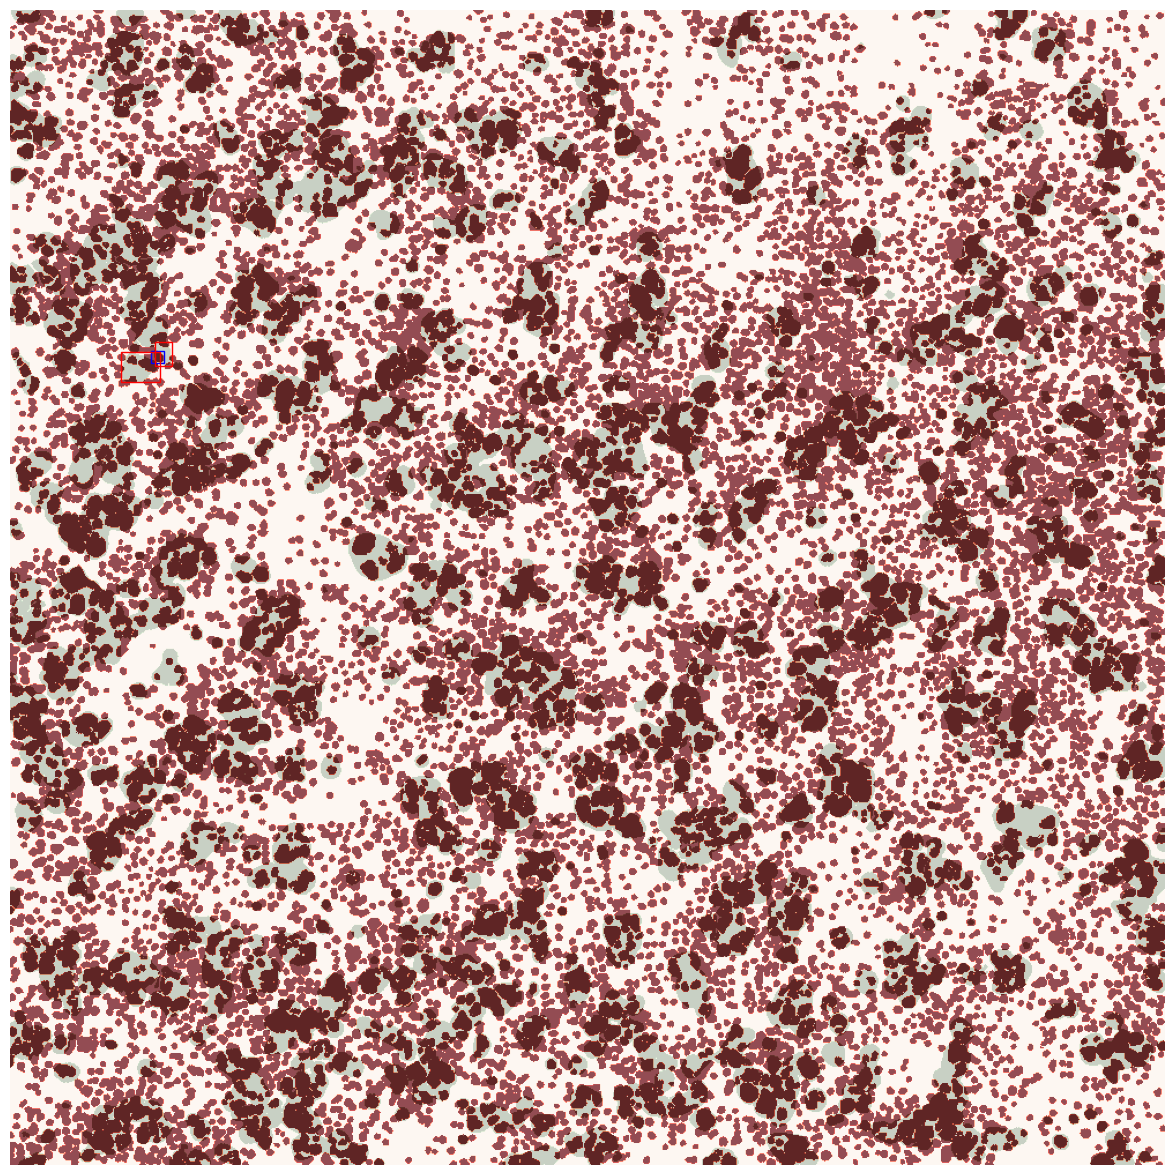

In [14]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
ax.set_axis_off()
frame = label_cancer[0,:,:].T
ax.imshow(exposure.rescale_intensity(frame, in_range=(0,1),out_range=(0,255)),cmap='Greens',alpha=0.7)
frame = label_tcell[0,:,:].T
ax.imshow(exposure.rescale_intensity(frame, in_range=(0,1),out_range=(0,255)),cmap='Reds',alpha=0.7)

# Create a Rectangle patch
TCELL_LABEL_ID = 1000

rect = patches.Rectangle((features["tcell"].bbox_istart.iloc[TCELL_LABEL_ID], features["tcell"].bbox_jstart.iloc[TCELL_LABEL_ID]), features["tcell"].bbox_isize.iloc[TCELL_LABEL_ID], features["tcell"].bbox_jsize.iloc[TCELL_LABEL_ID], linewidth=1, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

f_1 = features["cancer"][features["cancer"].frame==0]

# Create a Rectangle patch
ids = res["feature"]["contacting cell labels"].iloc[TCELL_LABEL_ID]

for id in ids:
    id -= 1 # take care of label and pandas id column
    print(f_1.bbox_istart.iloc[id], f_1.bbox_jstart.iloc[id], f_1.bbox_isize.iloc[id], f_1.bbox_jsize.iloc[id])
    rect = patches.Rectangle((f_1.bbox_istart.iloc[id], f_1.bbox_jstart.iloc[id]), f_1.bbox_isize.iloc[id], f_1.bbox_jsize.iloc[id], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

## 3. Contact Time Plotting

Regardless of the cell size and cluster formations, here we demonstrate how to purify the cell contact analysis table and generate relevant plots.

Here we load the original track file generated by ultrack 

In [15]:
# Load tracking file and merge with the contact analysis table
TRACK_PATH = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/Tcell_tracks/tracks/tracks_param_00000.csv"

tracks_df = pd.read_csv(TRACK_PATH)
tracks_df = tracks_df.sort_values(by=["t"])
tracks_df = tracks_df[tracks_df["t"] < FRAMES]
tracks_df

track_id   t      y      x         id  parent_track_id  parent_id
0               1   0    1.0   21.0    1000002               -1         -1
1852152     10456   0  444.0   83.0    1017364               -1         -1
1852146     10455   0  443.0  521.0    1017357               -1         -1
1851890     10454   0  442.0  205.0    1017354               -1         -1
2489838     14040   0  725.0  289.0    1023456               -1         -1
...           ...  ..    ...    ...        ...              ...        ...
4110667     27807  99  539.0  255.0  100020961               -1   99020947
4483708     32693  99  715.0  776.0  100026947               -1   99027159
4520978     33366  99  894.0   38.0  100031430               -1   99031036
1692792      9594  99  439.0  421.0  100015870               -1   99015338
4110388     27801  99  574.0  337.0  100019404               -1   99019639

[1155561 rows x 7 columns]

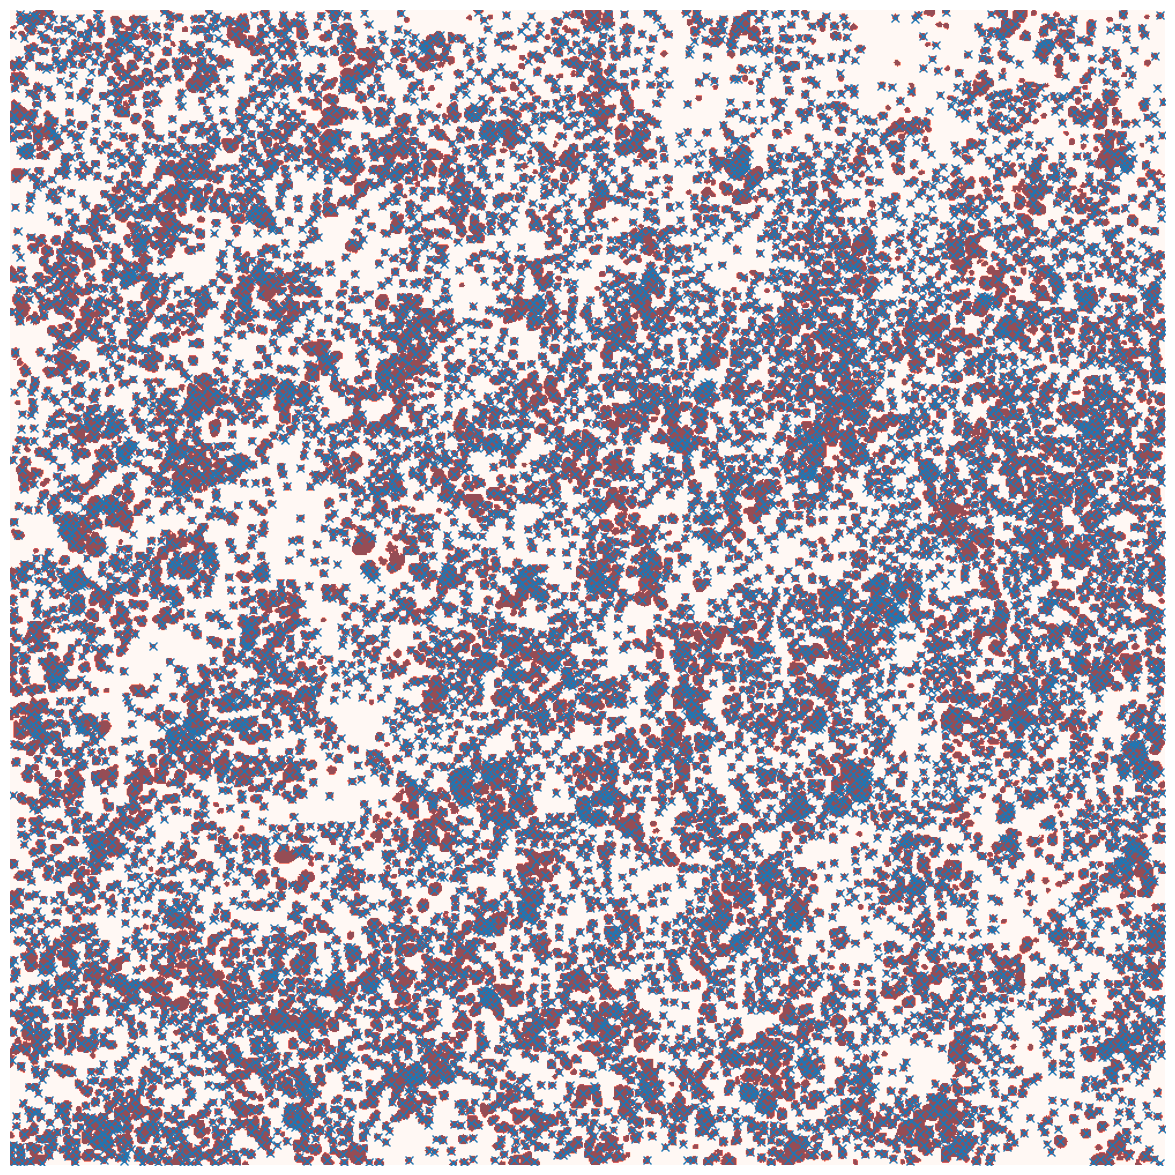

In [16]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
ax.set_axis_off()
frame = label_tcell[0,:,:].T
ax.imshow(exposure.rescale_intensity(frame, in_range=(0,1),out_range=(0,255)),cmap='Reds',alpha=0.7)
ax.plot(tracks_df[tracks_df.t==0].y,tracks_df[tracks_df.t==0].x,"x",label="T Cells")

Ultrack reassigns the label ids, we need to remap back to the original segmentaiton ids by position matching

In [17]:
from sklearn.neighbors import KDTree

tcell_df = features["tcell"]

# iterate over frames
tcell_df_remapped = []
for t in range(FRAMES):
    tcell_t_df = tcell_df[tcell_df["frame"]==t]
    tracks_t_df = tracks_df[tracks_df["t"]==t]
    points_tcell = tcell_t_df[["y","x"]].values
    points_ultrack = tracks_t_df[["x","y"]].values

    # build KD-Tree for each point in ultrack df
    kdtree_ultrack = KDTree(points_ultrack)

    # query closest point for each point in t cell df
    dist, indices = kdtree_ultrack.query(points_tcell,k=1)

    dist = [d[0] for d in dist]
    indices = [i[0] for i in indices]

    remapped_track_ids = pd.DataFrame(tracks_t_df[["track_id","id"]].iloc[indices])
    remapped_track_ids["dist_from_ultrack"] = dist

    tcell_t_df.reset_index(drop=True,inplace=True)
    remapped_track_ids.reset_index(drop=True,inplace=True)
    tcell_t_df_remapped = pd.concat([tcell_t_df,remapped_track_ids],axis=1)

    tcell_df_remapped.append(tcell_t_df_remapped)

tcell_df_remapped = pd.concat(tcell_df_remapped)
tcell_df_remapped

label           y           x  bbox_xstart  bbox_ystart  bbox_xsize  \
0            1  670.849246  390.738693          378          655          25   
1            2  132.066532  630.483871          618          116          24   
2            3  274.956790  865.415638          851          264          30   
3            4  691.069930  680.552448          667          675          25   
4            5  659.125874  729.431235          717          648          29   
...        ...         ...         ...          ...          ...         ...   
10017  1006718  287.200000  967.133333          965          285           5   
10018  1006719  284.800000  973.933333          972          283           5   
10019  1006720  769.200000  975.800000          974          768           5   
10020  1006721  131.600000  992.400000          991          130           4   
10021  1006722   89.200000  993.933333          992           88           5   

       bbox_ysize           i           j  bbox_istart  ...           sd  \
0              35  390.738693  670.849246        378.0  ...  2274.345323   
1              32  630.483871  132.066532        618.0  ...  4148.664472   
2              23  865.415638  274.956790        851.0  ...  1875.136901   
3              28  680.552448  691.069930        667.0  ...  3270.370277   
4              22  729.431235  659.125874        717.0  ...  1809.146731   
...           ...         ...         ...          ...  ...          ...   
10017           5  967.133333  287.200000        965.0  ...   177.095078   
10018           5  973.933333  284.800000        972.0  ...   167.495274   
10019           4  975.800000  769.200000        974.0  ...   286.050145   
10020           4  992.400000  131.600000        991.0  ...    82.687766   
10021           4  993.933333   89.200000        992.0  ...    64.756540   

       frame  channel  alive  contact  contacting cell labels  \
0          0    tcell    NaN     True                    [30]   
1          0    tcell    NaN     True                     [2]   
2          0    tcell    NaN     True              [240, 250]   
3          0    tcell    NaN     True                    [59]   
4          0    tcell    NaN     True                [19, 43]   
...      ...      ...    ...      ...                     ...   
10017     99    tcell    NaN    False                      []   
10018     99    tcell    NaN    False                      []   
10019     99    tcell    NaN     True        [120264, 120695]   
10020     99    tcell    NaN    False                      []   
10021     99    tcell    NaN    False                      []   

       closest cell dist  track_id         id  dist_from_ultrack  
0               1.678074      8983    1014979           1.270284  
1              10.591233     13740    1022893           2.130011  
2               4.563784     19479    1032496           5.415810  
3               2.580832     15322    1025484           1.981281  
4               6.320714     16304    1027251           1.923100  
...                  ...       ...        ...                ...  
10017          10.618454     31363  100034029           4.596134  
10018          12.628018     24077  100034025           2.444949  
10019           9.078635     20942  100033336           7.244308  
10020          41.155411     35511  100035491           0.565685  
10021          45.172066     32847  100035490          10.242613  

[1006722 rows x 33 columns]

Save the remapped tracks dataframe

In [18]:
# save tracks
tcell_df_remapped.to_csv("/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/Tcell_tracks/tracks/tcell_tracks.csv")